In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import EllipticEnvelope
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import EllipticEnvelope
import os
import re
from glob import glob

Aqui é realizada a etapa de pré-processamento e correção de sazonalidade
* hr é o dataframe (df) relacionado à freq cardíaca
* step é relacionado à passos

In [33]:
#corrige o index da base de dados
def set_datetime_as_index(df) :
    df [ 'datetime' ] = pd.to_datetime ( df [ 'datetime' ] )
    df = df.set_index ( 'datetime' )
    df.index.name = 'datetime'
    return df

#realiza o calculo do rhr
#os dados de passos e batimentos são juntados em um dataframe
#em seguida as linhas no qual os valores de passo é maior que zero são deletadas
def set_rhr(df_hr, df_steps):
    df_hr = set_datetime_as_index(df_hr)
    df_steps = set_datetime_as_index(df_steps)

    df = pd.merge(df_hr, df_steps, left_index=True, right_index=True)
    df = df.resample('1min').mean()
    df = df.dropna()

    df['steps_window_12'] = df['steps'].rolling(12).sum()
    df = df.loc[(df['steps_window_12'] == 0)]

    return df #retorna o df do rhr

def pre_processing(df):
    # smooth data
    df_nonas = df.dropna()
    df1_rom = df_nonas.rolling(400).mean()
    # reamostra em dois dias
    df1_resmp = df1_rom.resample('2D').mean()
    df2 = df1_resmp.drop(['steps'], axis=1)
    df2 = df2.dropna()
    print("preprocess ok")
    return df2

#faz a correção de sazonalidade
def seasonality_correction(resting_heart_rate, steps):
    sdHR = resting_heart_rate[['heartrate']]
    sdSteps = resting_heart_rate[['steps_window_12']]
    sdHR_decomposition = seasonal_decompose(sdHR, model='additive', period = 1)
   # result.plot()
   # pyplot.show()
    sdSteps_decomposition = seasonal_decompose(sdSteps, model='additive', period = 1)
    sdHR_decomp = pd.DataFrame(sdHR_decomposition.resid + sdHR_decomposition.trend)
    sdHR_decomp.rename(columns={sdHR_decomp.columns[0]:'heartrate'}, inplace=True)
    sdSteps_decomp = pd.DataFrame(sdSteps_decomposition.resid + sdSteps_decomposition.trend)
    sdSteps_decomp.rename(columns={sdSteps_decomp.columns[0]:'steps_window_12'}, inplace=True)
    frames = [sdHR_decomp, sdSteps_decomp]
    data = pd.concat(frames, axis=1)
    
    return data



In [34]:
#Lendo a pasta com os arquivos e associando cada arquivo de hr com um de steps em um dicionario
dicHrSteps = {}
folder = glob('./COVID-19-Wearables/*')
folder = sorted(folder)
#print(folder)
j = 0
for i in range((len(folder)//2)):
    dicHrSteps[folder[j]] = folder[j+1]
    j+=2
#print("-----"*10)
print(dicHrSteps)

{'./COVID-19-Wearables\\A06L7KF_hr.csv': './COVID-19-Wearables\\A06L7KF_steps.csv', './COVID-19-Wearables\\A0822M0_hr.csv': './COVID-19-Wearables\\A0822M0_steps.csv', './COVID-19-Wearables\\A0KX894_hr.csv': './COVID-19-Wearables\\A0KX894_steps.csv', './COVID-19-Wearables\\A0L9BM2_hr.csv': './COVID-19-Wearables\\A0L9BM2_steps.csv', './COVID-19-Wearables\\A0NVTRV_hr.csv': './COVID-19-Wearables\\A0NVTRV_steps.csv', './COVID-19-Wearables\\A0VFT1N_hr.csv': './COVID-19-Wearables\\A0VFT1N_steps.csv', './COVID-19-Wearables\\A11SQQN_hr.csv': './COVID-19-Wearables\\A11SQQN_steps.csv', './COVID-19-Wearables\\A11V1FH_hr.csv': './COVID-19-Wearables\\A11V1FH_steps.csv', './COVID-19-Wearables\\A17YCA2_hr.csv': './COVID-19-Wearables\\A17YCA2_steps.csv', './COVID-19-Wearables\\A1K5DRI_hr.csv': './COVID-19-Wearables\\A1K5DRI_steps.csv', './COVID-19-Wearables\\A1ZJ41O_hr.csv': './COVID-19-Wearables\\A1ZJ41O_steps.csv', './COVID-19-Wearables\\A2D7K4A_hr.csv': './COVID-19-Wearables\\A2D7K4A_steps.csv', './

In [17]:
#nessa célula eu realizava os testes pra saber o que estava acontecendo
#note que é importante definir um df pra hr e outra pra steps
#em seguida, com df de hr e steps, é calculado o df do rhr


dfHr = pd.read_csv("COVID-19-Wearables/AA2KP1S_hr.csv")
dfStep = pd.read_csv("COVID-19-Wearables/AA2KP1S_steps.csv")
dfRhr = set_rhr(dfHr, dfStep)
dfRhr = pre_processing(dfRhr)
sdHR_decomposition = seasonal_decompose(dfRhr[['heartrate']], model='additive', period=14)
sdHR_decomposition.plot()
#plt.savefig('teste.png', format='png')
#plt.show()

#data = seasonality_correction(dfRhr, dfStep)
#data = data.drop(columns=['steps_window_12'])




preprocess ok


<AxesSubplot:xlabel='datetime'>

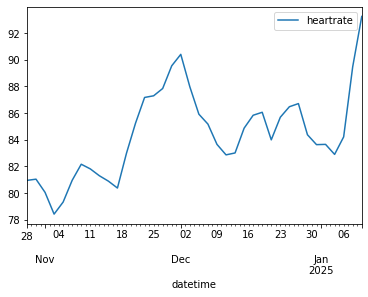

In [25]:
#plotando o rhr
dfRhr.drop(columns=['steps_window_12']).plot()

In [35]:
#aqui ocorria a concatenação de rhrs de diversos indivíduos em um só DF
#pra isso utilizava o dic criado anteriormente pra associar cada step com hr
dfGeral = pd.DataFrame()
i = 1
for chave, valor in dicHrSteps.items():
    nome = str(chave)
    nome = nome.replace("./COVID-19-Wearables\\", "")
    nome = nome.replace("_hr.csv", "")
    print(nome, " - ",i )
    dfHr = pd.read_csv(chave)
    dfSteps = pd.read_csv(valor)
    dfRhr = set_rhr(dfHr, dfSteps)
    dfRhr = pre_processing(dfRhr)
    #dfRHr = seasonality_correction(dfRhr, dfSteps)
    dfRhr = dfRhr.reset_index(drop=True)
    dfRhr = dfRhr.drop(columns=['steps_window_12'])
    dfRhr = dfRhr.dropna()
    dfRhr= dfRhr.rename(columns={"heartrate": str(nome)})
    dfGeral = pd.concat([dfGeral, dfRhr],axis=1)
    #print(nome, " - ",i )
    #print(i)
    i+=1
    
print("OK")

A06L7KF  -  1
preprocess ok
A0822M0  -  2
preprocess ok
A0KX894  -  3
preprocess ok
A0L9BM2  -  4
preprocess ok
A0NVTRV  -  5
preprocess ok
A0VFT1N  -  6
preprocess ok
A11SQQN  -  7
preprocess ok
A11V1FH  -  8
preprocess ok
A17YCA2  -  9
preprocess ok
A1K5DRI  -  10
preprocess ok
A1ZJ41O  -  11
preprocess ok
A2D7K4A  -  12
preprocess ok
A2P3LTM  -  13
preprocess ok
A2XFW2N  -  14
preprocess ok
A35BJNV  -  15
preprocess ok
A36HR6Y  -  16
preprocess ok
A3OU183  -  17
preprocess ok
A45F9E6  -  18
preprocess ok
A4E0D03  -  19
preprocess ok
A4G0044  -  20
preprocess ok
A4H7SNF  -  21
preprocess ok
A5XL2IC  -  22
preprocess ok
A65HVGP  -  23
preprocess ok
A6BUI4N  -  24
preprocess ok
A6GEBIK  -  25
preprocess ok
A7EAWA7  -  26
preprocess ok
A7EM0B6  -  27
preprocess ok
A8CBEJZ  -  28
preprocess ok
A8QLAB0  -  29
preprocess ok
A91HEZV  -  30
preprocess ok
A99ZKKW  -  31
preprocess ok
A9ZG5GR  -  32
preprocess ok
AA0HAI1_1  -  33
preprocess ok
AA0HAI1_2  -  34
preprocess ok
AA0HAI1_3  -  35
pr

<AxesSubplot:>

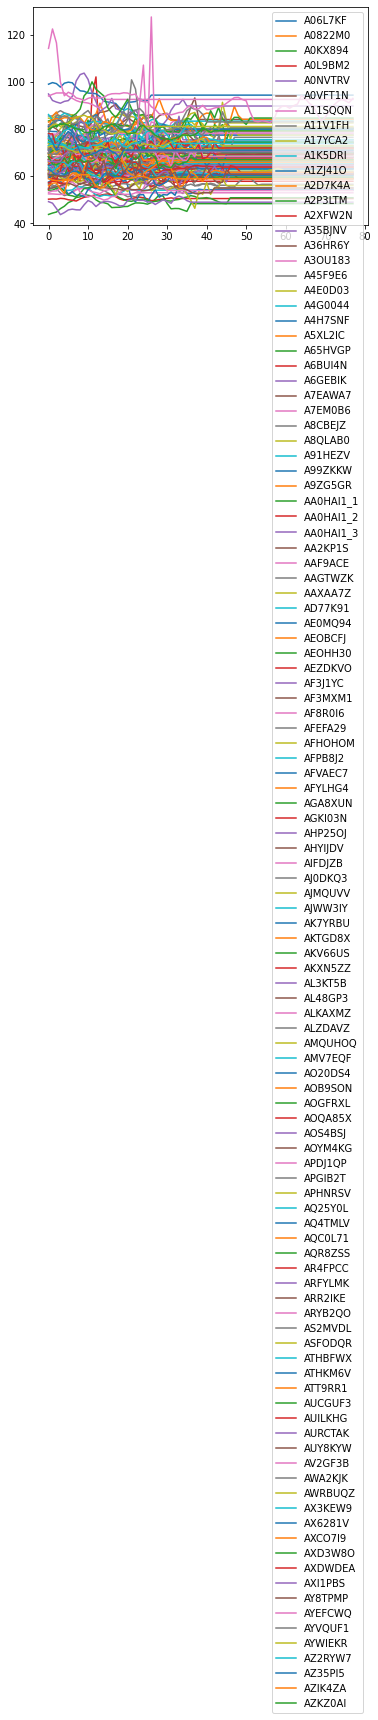

In [36]:
#preenchendo os valores ausentes com a mediana
dfGeral2 = dfGeral.fillna(dfGeral.median())
dfGeral2.plot()

In [37]:
#transpondo o DF para cada hr de cada período ser uma feature
#em seguida salvando no computador
dfGeralTransp = dfGeral2.transpose()
dfGeralTransp
dfGeralTransp.to_csv('dadosTREINO1.csv', index=True)

<AxesSubplot:>

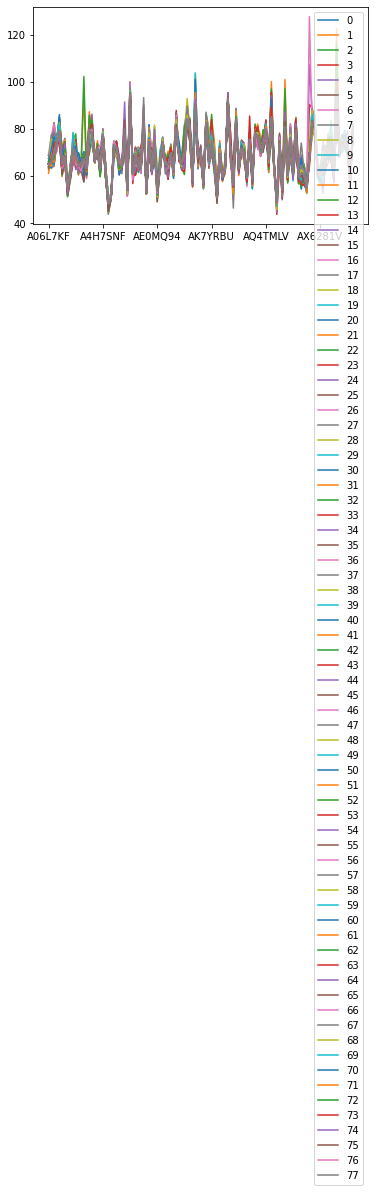

In [38]:
dfGeralTransp.plot()